In [1]:
# Import required libraries for data manipulation and analysis
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import shap
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

In [2]:
#Import required sklearn functions
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.inspection import permutation_importance
from collections import defaultdict

In [3]:
#Import sklearn classifiers
from sklearn.ensemble import RandomForestClassifier

In [4]:
#Import library to oversample 
from imblearn.over_sampling import RandomOverSampler

In [5]:
#Import RDKit and Mordred libraries
from rdkit import Chem
from rdkit.Chem import Draw
from mordred import Calculator, descriptors

In [6]:
#Allows figures to be visualized in jupyter notebook
%matplotlib inline

In [7]:
#Functions used in the study

#Remove those numbers from analysis data
def filter_rows_by_values1(df, col, values):
    return df[~df[col].isin(values)]

#Remove those numbers from analysis data
def filter_rows_by_values2(df, col, values):
    return df[df[col].isin(values)]

#Get Mordred calcs
def get_Mordred(data_input):
    # Assigns Reactants Mordred Info
    reactants = data_input['Substrate']
    
    reactants_mol_list = []
    for inChi_reactants in reactants:
      reactants_mol = Chem.MolFromInchi(inChi_reactants)
      reactants_mol_list.append(reactants_mol)

    # Puts reactants into Pandas Type
    reactant_data = []
    reactant_data = calc.pandas(reactants_mol_list)
       
    #Joins Mordred parameters with experimental, atomic charges, and JChem for Excel parameters
    add_reactants = pd.concat((data_input, reactant_data), axis=1)
    
    #Force any non-numeric entries as NaN and replace them with 0
    int_data = add_reactants.apply(pd.to_numeric, errors='coerce')
    
    output = int_data.fillna(0)#, inplace=True)

    return output

#Remove zero varience
def remove_zero_varience(values):
   sel = VarianceThreshold()
   _ = sel.fit(values)
   mask = sel.get_support()
   values = values.loc[:,mask] 
   return values

def remove_95correlated(correlated):
    #Remove any features that are greater than 95% correlated
    corr_matrix = correlated.corr()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))

    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]

    correlated = correlated.drop(to_drop, axis = 1)
    corr_matrix = correlated.corr()
    return correlated

def remove_nonimportant(X_values, y_values):
    # Specifys Random Forest and the Number of Trees, SelectFromModel will
    # select features which are most important
    feature_names = [f"feature {i}" for i in range(X_values.shape[1])]
    forest = RandomForestClassifier(random_state=42)
    forest.fit(X_values, y_values)

    start_time = time.time()
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    elapsed_time = time.time() - start_time

    threshold = np.sort(importances)[-100]
    
    sel = SelectFromModel(RandomForestClassifier(n_estimators = 800, max_depth=30),threshold=threshold)
    sel.fit(X_values, y_values)

    # Select the final features set 
    sel.get_support()
    selected_feat= X_values.columns[(sel.get_support())]

    # Prints the names of the final selected features
    print(selected_feat)
    X_values = X_values[selected_feat]
    
    return X_values

def dendrogram(X_values, y):
    corr = spearmanr(X_values).correlation
    # Ensure the correlation matrix is symmetric
    corr = (corr + corr.T) / 2
    np.fill_diagonal(corr, 1)
    distance_matrix = 1 - np.abs(corr)
    dist_linkage = hierarchy.ward(squareform(distance_matrix))
  
    trained_cluster_ids = hierarchy.fcluster(dist_linkage, y, criterion="distance")
    trained_cluster_id_to_feature_ids = defaultdict(list) 
    for idx, trained_cluster_id in enumerate(trained_cluster_ids):
        trained_cluster_id_to_feature_ids[trained_cluster_id].append(idx)
    
    trained_selected_features = [v[0] for v in trained_cluster_id_to_feature_ids.values()]
    final_selected_features = X_values.columns[trained_selected_features]
    X_train = X_values[final_selected_features]
    return X_train

def classificationMetrics(results, y_test, pred):
    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred, average=None, zero_division=0)
    recall = recall_score(y_test, pred, average=None)
    F1 = f1_score(y_test, pred, average=None)           
    #Calculate confusion matrix
    cf_matrix = confusion_matrix(y_test, pred)
    cf_matrix = np.reshape(cf_matrix,(1,4))
    comb = np.concatenate((x, y, cf_matrix, acc, prec, recall, F1), axis=None)
    comb = [comb]
    results = results.append(pd.DataFrame(comb, columns=results.columns), ignore_index=True)
    return results


In [8]:
# Sets Pandas Display to Monitor Code
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 10)

In [9]:
# Create Mordred Calculator
calc = Calculator(descriptors, ignore_3D=True)

In [10]:
# Read Training/Test data input File
data = pd.read_csv('BorylationTrainingTest 1-10-25.csv')
data

,Substrate,Product,Boronic Ester,Active Catalyst-Ligand,Catalyst,...,Ring Atom Count,Rot Bond Count,Sigma Electronegativity,Wiener Index,Product_Ratio
0,"InChI=1S/C8H18/c1-3-5-7-8-6-4-2/h3-8H2,1-2H3",InChI=1S/C14H29BO2/c1-6-7-8-9-10-11-12-15-16-1...,2,6,1,...,0,5,7.387931,84,1
1,"InChI=1S/C8H18/c1-3-5-7-8-6-4-2/h3-8H2,1-2H3",InChI=1S/C14H29BO2/c1-7-8-9-10-11-12(2)15-16-1...,2,6,1,...,0,5,7.470532,84,0
2,"InChI=1S/C8H18/c1-3-5-7-8-6-4-2/h3-8H2,1-2H3",InChI=1S/C14H29BO2/c1-7-9-10-11-12(8-2)15-16-1...,2,6,1,...,0,5,7.493894,84,0
3,"InChI=1S/C8H18/c1-3-5-7-8-6-4-2/h3-8H2,1-2H3",InChI=1S/C14H29BO2/c1-7-9-11-12(10-8-2)15-16-1...,2,6,1,...,0,5,7.496149,84,0
4,"InChI=1S/C7H15N/c1-2-8-6-4-3-5-7-8/h2-7H2,1H3","InChI=1S/C13H26BNO2/c1-12(2)13(3,4)17-14(16-12...",2,7,3,...,6,1,7.937482,64,1
...,...,...,...,...,...,...,...,...,...,...,...
966,InChI=1S/C15H18/c1-10(2)13-7-5-11(3)14-8-6-12(...,InChI=1S/C21H29BO2/c1-14-8-10-17(12-19-15(2)9-...,2,5,6,...,10,1,7.447806,331,0
967,InChI=1S/C15H18/c1-10(2)13-7-5-11(3)14-8-6-12(...,InChI=1S/C21H29BO2/c1-13(2)17-12-18-14(3)9-10-...,2,5,6,...,10,1,8.374628,331,0
968,InChI=1S/C15H18/c1-10(2)13-7-5-11(3)14-8-6-12(...,InChI=1S/C21H29BO2/c1-13(2)16-11-18-14(3)9-10-...,2,5,6,...,10,1,8.291631,331,0
969,InChI=1S/C15H18/c1-10(2)13-7-5-11(3)14-8-6-12(...,InChI=1S/C21H29BO2/c1-14(2)16-9-10-17(18-11-8-...,2,5,6,...,10,1,7.959360,331,0


Counter({0: 782, 1: 189})


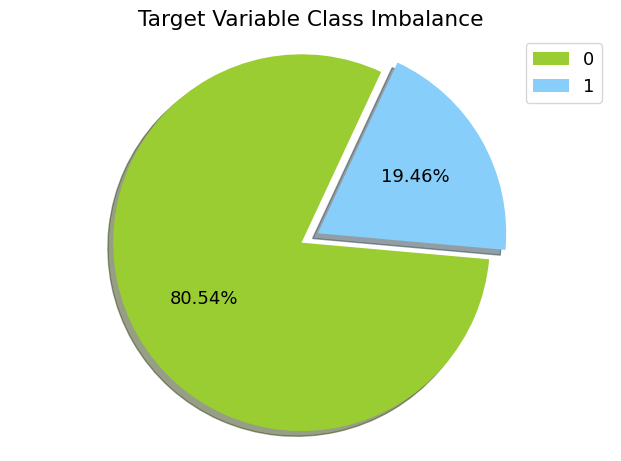

In [11]:
#Show dataset class imbalance
from collections import Counter
counter = Counter(data['Product_Ratio'])
print(counter)

#show target breakdown in pie chart format
plt.rcParams['font.size'] = 13
labels = ['0', '1']
sizes = [782, 189]
colors = ['yellowgreen', 'lightskyblue']
explode = (0, 0.1)
plt.title("Target Variable Class Imbalance")
patches, texts, junk = plt.pie(sizes, explode=explode, colors=colors, shadow=True, startangle=65,  autopct = '%.2f%%')
plt.legend(patches, labels, loc="best")
plt.axis('equal')

plt.tight_layout()
plt.show()

In [12]:
#group the compounds by numbers
data['grouped'] = data.groupby('Substrate', sort=False).ngroup()
data[['Substrate','grouped']]

,Substrate,grouped
0,"InChI=1S/C8H18/c1-3-5-7-8-6-4-2/h3-8H2,1-2H3",0
1,"InChI=1S/C8H18/c1-3-5-7-8-6-4-2/h3-8H2,1-2H3",0
2,"InChI=1S/C8H18/c1-3-5-7-8-6-4-2/h3-8H2,1-2H3",0
3,"InChI=1S/C8H18/c1-3-5-7-8-6-4-2/h3-8H2,1-2H3",0
4,"InChI=1S/C7H15N/c1-2-8-6-4-3-5-7-8/h2-7H2,1H3",1
...,...,...
966,InChI=1S/C15H18/c1-10(2)13-7-5-11(3)14-8-6-12(...,188
967,InChI=1S/C15H18/c1-10(2)13-7-5-11(3)14-8-6-12(...,188
968,InChI=1S/C15H18/c1-10(2)13-7-5-11(3)14-8-6-12(...,188
969,InChI=1S/C15H18/c1-10(2)13-7-5-11(3)14-8-6-12(...,188


In [13]:
#Convert substrates to Mordred features
data = get_Mordred(data)

100%|██████████| 971/971 [01:21<00:00, 11.91it/s]


In [14]:
rfcResults_df = pd.DataFrame(columns =  ['x', 'y',  "True Neg","False Pos","False Neg","True Pos",'acc', 'precision 0',
                                   'precision 1','recall 0', 'recall 1', 'F1 0', 'F1 1'])

rfcmaxacc_comb = pd.DataFrame()
val_tot = pd.DataFrame()
prod = pd.DataFrame()
test_index_total = pd.DataFrame()

model_columns = pd.DataFrame()
for_range = range(1, 11)
for x in for_range:
    #Get numbers to represent compounds
    arr = np.arange(0, 188,  dtype=int)

    #Get 20% of numbers, without replacement
    set_numbers = np.random.choice(arr, int(len(arr)*0.20), replace=False ) 
    
    #Seperate training (80%) and test data (20%)
    training_data = filter_rows_by_values1(data, "grouped", set_numbers)
    training_data = training_data.drop('grouped', axis = 1)    
    test_data = filter_rows_by_values2(data, "grouped", set_numbers)
    test_data = test_data.drop('grouped', axis = 1)    
    
    #Remove features that dont change
    training_data = remove_zero_varience(training_data)
    
    #Remove features that are more than 95% correlated
    training_data = remove_95correlated(training_data)
    
    # Seperate dataset as response variable (Product Ratio) and feature variables
    #Note: Product Ratio is described as "0" for non-borylating sites and "1" for borylating sites
    training_X = training_data.drop('Product_Ratio', axis = 1)
    training_y = training_data['Product_Ratio']
    test_X = test_data.drop('Product_Ratio', axis = 1)
    test_y = test_data['Product_Ratio']
    
    #Remove features that are considered less important
    feature_names = [f"feature {i}" for i in range(training_X.shape[1])]
    forest = RandomForestClassifier(random_state=42)
    forest.fit(training_X, training_y)
    
    start_time = time.time()
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    elapsed_time = time.time() - start_time
    
    threshold = np.sort(importances)[-100] 
    sel = SelectFromModel(RandomForestClassifier(n_estimators = 800, max_depth=30),threshold=threshold)
    sel.fit(training_X, training_y)
     
    # Select the reduced features set 
    sel.get_support()
    selected_feat= training_X.columns[(sel.get_support())]
    
    reduced1_X = training_X[selected_feat]
    test_X = test_X[selected_feat]
    
    #Apply over-sampling to dataset
    ros = RandomOverSampler(random_state=10)
    X_resampled, y_resampled = ros.fit_resample(reduced1_X, training_y) 
    
    for y in [ 
              0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35,
              0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 
              0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45,
              0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50
             ]:
    
        #Make final training and test set and save them as df's  
        X_train = dendrogram(X_resampled, y)
        test_X = test_X[X_train.columns]
        training_columns_list = X_train.columns.tolist()
        training_columns_list = (x, y, training_columns_list)
        training_columns_list = (pd.DataFrame(training_columns_list).T)

        #Random Forest Classifier
        rfc = RandomForestClassifier(n_estimators=800,max_depth=9)
        rfc.fit(X_train, y_resampled)
        pred_rfc = rfc.predict(test_X)
        rfcResults_df = classificationMetrics(rfcResults_df, test_y, pred_rfc)
         

        #Evaluate model by going line by line
        ynew = rfc.predict(test_X)
        prediction_df = pd.DataFrame(ynew,  columns = [(x,y)])

        val_pred_T = prediction_df.T
        val_tot = val_tot.append(val_pred_T)

        #Determine the mean accuracy of the different dendrogram settings
        acc_mean = rfcResults_df.groupby('y')['acc'].mean()
        acc_std = rfcResults_df.groupby('y')['acc'].std()
        precision_0_mean = rfcResults_df.groupby('y')['precision 0'].mean()
        precision_0_std = rfcResults_df.groupby('y')['precision 0'].std()
        precision_1_mean = rfcResults_df.groupby('y')['precision 1'].mean()
        precision_1_std = rfcResults_df.groupby('y')['precision 1'].std()
        recall_0_mean = rfcResults_df.groupby('y')['recall 0'].mean()
        recall_0_std = rfcResults_df.groupby('y')['recall 0'].std()
        recall_1_mean = rfcResults_df.groupby('y')['recall 1'].mean()
        recall_1_std = rfcResults_df.groupby('y')['recall 1'].std()
        F1_0_mean = rfcResults_df.groupby('y')['F1 0'].mean()
        F1_0_std = rfcResults_df.groupby('y')['F1 0'].std()
        F1_1_mean = rfcResults_df.groupby('y')['F1 1'].mean()
        F1_1_std = rfcResults_df.groupby('y')['F1 1'].std()
        true_neg_mean = rfcResults_df.groupby('y')['True Neg'].mean()
        true_neg_std = rfcResults_df.groupby('y')['True Neg'].std()
        false_pos_mean = rfcResults_df.groupby('y')['False Pos'].mean()
        false_pos_std = rfcResults_df.groupby('y')['False Pos'].std()        
        false_neg_mean = rfcResults_df.groupby('y')['False Neg'].mean()
        false_neg_std = rfcResults_df.groupby('y')['False Neg'].std()      
        true_pos_mean = rfcResults_df.groupby('y')['True Pos'].mean() 
        true_pos_std = rfcResults_df.groupby('y')['True Pos'].std()   
        

        rfcaverage_df = pd.concat([acc_mean , acc_std, 
                                   precision_0_mean, precision_0_std, 
                                   precision_1_mean, precision_1_std, 
                                   recall_0_mean, recall_0_std, 
                                   recall_1_mean, recall_1_std,
                                   F1_0_mean, F1_0_std,
                                   F1_1_mean, F1_1_std,
                                   true_neg_mean, true_neg_std,
                                   false_pos_mean, false_pos_std,
                                   false_neg_mean, false_neg_std,
                                   true_pos_mean, true_pos_std], axis=1)
    
        rfcaverage_df.columns = ['acc_mean' , 'acc_std', 'precision_0_mean', 'precision_0_std', 
                                 'precision_1_mean', 'precision_1_std', 'recall_0_mean', 'recall_0_std', 
                                 'recall_1_mean','recall_1_std', 'F1_0_mean', 'F1_0_std', 
                                 'F1_1_mean', 'F1_1_std', 'true_neg_mean', 'true_neg_std',
                                 'false_pos_mean', 'false_pos_std','false_neg_mean', 'false_neg_std',
                                 'true_pos_mean', 'true_pos_std']                                 
               
        rfcmaxacc = rfcaverage_df[rfcaverage_df.acc_mean == rfcaverage_df.acc_mean.max()]
        rfcmaxacc_copy  = rfcmaxacc.copy()
        rfcmaxacc_copy['x_col'] = x
        
        model_columns = model_columns.append(training_columns_list)

    test_index = pd.DataFrame(test_data.index.values, columns = [x])

    test_index_total = pd.concat([test_index_total, test_index],axis = 1)
    test_y = test_y.rename(x)
    test_y = test_y.reset_index(drop = True)
    prod = prod.append(test_y)
    rfcmaxacc_comb = rfcmaxacc_comb.append(rfcmaxacc_copy)  
prod = prod.T
total_results = val_tot.T

rfcmaxacc_comb.to_csv("10Runs_rfc.csv")
model_columns = model_columns.rename(columns = {0:'x', 1:'y', 2: 'features'})
model_columns = model_columns.drop_duplicates(subset = ['x','y'])
model_columns.to_csv("10Runs_rfc.csv",mode="a", index=False)

test_index_total.to_csv("10Runs_rfc.csv", mode="a")
prod.to_csv("10Runs_rfc.csv", mode="a")
total_results.to_csv("10Runs_rfc.csv", mode="a")

In [15]:
rfcmaxacc_comb

,acc_mean,acc_std,precision_0_mean,precision_0_std,precision_1_mean,...,false_neg_mean,false_neg_std,true_pos_mean,true_pos_std,x_col
y,,,,,,,,,,,
0.35,0.865128,0.003461,0.922389,0.001850,0.636960,...,12.100000,0.316228,24.900000,0.316228,1
0.35,0.888555,0.024541,0.938586,0.016755,0.680448,...,10.050000,2.139233,26.950000,2.139233,2
0.35,0.869476,0.034458,0.928565,0.020082,0.645494,...,10.966667,2.235811,26.033333,2.235811,3
0.35,0.869784,0.029833,0.925650,0.018191,0.649271,...,11.600000,2.262288,25.400000,2.262288,4
0.35,0.860608,0.032577,0.922598,0.017416,0.621498,...,12.160000,2.324317,24.840000,2.324317,5
0.35,0.866875,0.032981,0.922339,0.016010,0.642083,...,12.700000,2.479065,24.300000,2.479065,6
0.35,0.854888,0.042659,0.917788,0.018743,0.618022,...,13.000000,2.437628,24.000000,2.437628,7
0.35,0.851340,0.041057,0.917873,0.017582,0.606374,...,12.937500,2.296633,24.062500,2.296633,8
0.35,0.848059,0.039842,0.916374,0.017213,0.599113,...,13.044444,2.207806,23.955556,2.207806,9
